# Predicting Song Popularity <br>
Arriana Daniels<br>
George  Rodriguez<br>
Jude Zhu<br>
W207


Many organizations and teams have embarked on the journey of quantifying music at scale <br>
For any music platform, the better can quantify music, the better they can tune their systems and algorithms to generate revenue<br>
In this project, we took a spotify dataset containing 18,835 songs along with the song specific characteristics and aggregated user ratings to build machine learning models to predict song populartiy


In [45]:
#basic libraries
import numpy as np # array manipulation
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for EDA, plot illustration
from mpl_toolkits.mplot3d import Axes3D #for 3d plots
import seaborn as sns #another plotting library
import warnings
import os

# SK-learn libraries for training
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# Load Data

In [3]:
#load the data
song_data_original = pd.read_csv("data/song_data.csv")
song_info_original = pd.read_csv("data/song_info.csv") 
#make copies of the data for manipulation later
song_info = song_info_original.copy()
song_data = song_data_original.copy()

# Data Cleaning

In [5]:
song_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


There are a mix of float and integer data types. 

### Data Cleaning - Remove Duplicates

In [5]:
#check for missing values
print(song_data.isnull().values.any())

#remove duplicative rows 
song_data = song_data.drop_duplicates()
#remove error rows (time_signature cannot be 0)
i = song_data[song_data.time_signature == 0].index
song_data = song_data.drop(i)
print(len(i))

#index of duplicative rows
idx = song_data_original.index.difference(song_data.index)
print(len(idx))

#remove the corresponding rows in song_data
song_info = song_info_original.drop(idx)
song_info = song_info_original.drop(i)
#reset index
song_data = song_data.reset_index(drop=True)
song_info = song_info.reset_index(drop=True)
#check for shape
song_data.shape
song_data_original.shape

False
0
3912


(18835, 15)

### Data Cleaning - Defining Popularity<br>
Seeing as our goal for this project was to create an algorithm that can predict whether a song will be popular or not, it was critical for us to determine what we would define as a "popular" song. Looking at the above description of the data, we found that the top quartile popularity score was 64. Spotify calculated the popularity of a song mostly based on the total number plays a song has and how recent those plays are. 

In [7]:
#define popularity
pop = np.quantile(song_data.song_popularity,0.75)
#binarize popularity, using the mean popularity score as cutoff (48.75)
song_data["popular"]= [ 1 if i>= pop else 0 for i in song_data.song_popularity ]
song_data["popular"].value_counts()

0    11191
1     3732
Name: popular, dtype: int64

### Data Cleaning Summary
- there is no null values to remove <br>
- after removing duplicative rows, we are left with 14,923 unique rows. Rows with only the same song names are preserved

# EDA

### Distribution of features

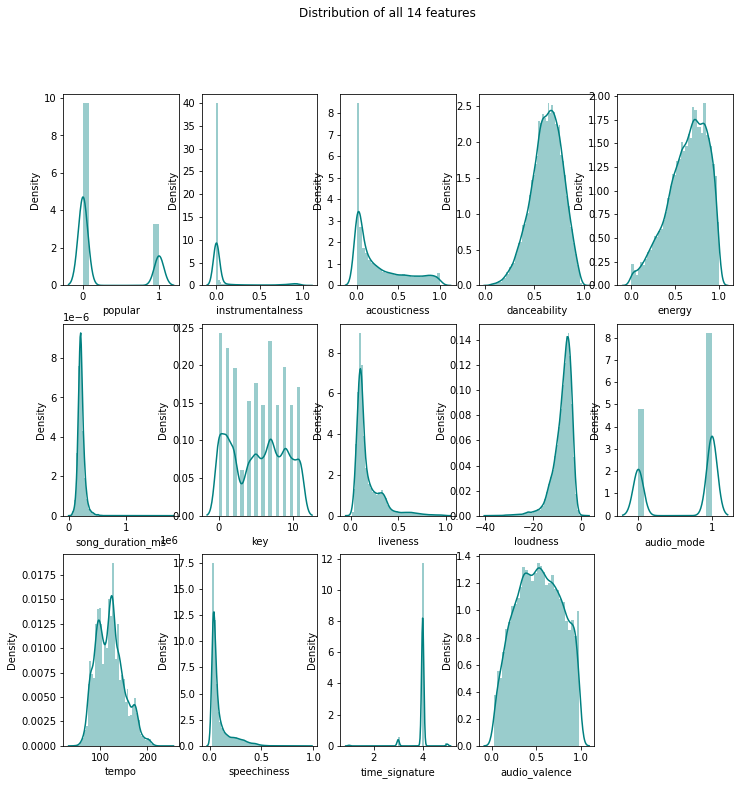

In [11]:
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(3, 5, figsize=(12, 12))
sns.distplot( song_data["popular"] , color="teal", ax=axes[0, 0])
sns.distplot( song_data["song_duration_ms"] , color="teal", ax=axes[1, 0])
sns.distplot( song_data["instrumentalness"] , color="teal", ax=axes[0, 1])
sns.distplot( song_data["acousticness"] , color="teal", ax=axes[0, 2])
sns.distplot( song_data["danceability"] , color="teal", ax=axes[0, 3])
sns.distplot( song_data["energy"] , color="teal", ax=axes[0, 4])
sns.distplot( song_data["key"] , color="teal", ax=axes[1, 1])
sns.distplot( song_data["liveness"] , color="teal", ax=axes[1, 2])
sns.distplot( song_data["loudness"] , color="teal", ax=axes[1, 3])
sns.distplot( song_data["audio_mode"] , color="teal", ax=axes[1, 4])
sns.distplot( song_data["tempo"] , color="teal", ax=axes[2, 0])
sns.distplot( song_data["speechiness"] , color="teal", ax=axes[2, 1])
sns.distplot( song_data["time_signature"] , color="teal", ax=axes[2, 2])
sns.distplot( song_data["audio_valence"] , color="teal", ax=axes[2, 3])
fig.delaxes(axes[2][4])
fig.suptitle("Distribution of all 14 features")
plt.show()

Looking at the distribution of outcomes (popular vs. unpopular), our data seems unbalanced, which may impact the result of model predictions.

# Feature Analysis

### Visulize correlation between features

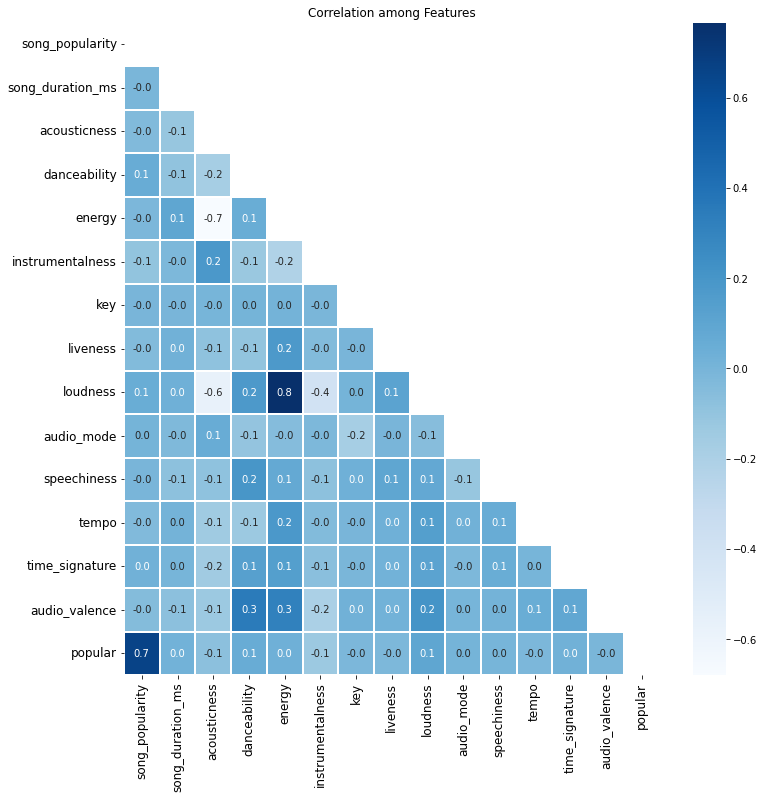

In [12]:
fig,ax = plt.subplots(figsize=(12, 12))
mask = np.zeros_like(song_data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(song_data.corr(), annot=True, linewidths=0.4,linecolor="white", fmt= '.1f',ax=ax,cmap="Blues",mask=mask)
ax.set_title("Correlation among Features")
plt.xticks(rotation = 90, size = 12)
plt.yticks(size = 12)
plt.show() 

Loudness and energy seems to be highly correlated.

### Range of feature values

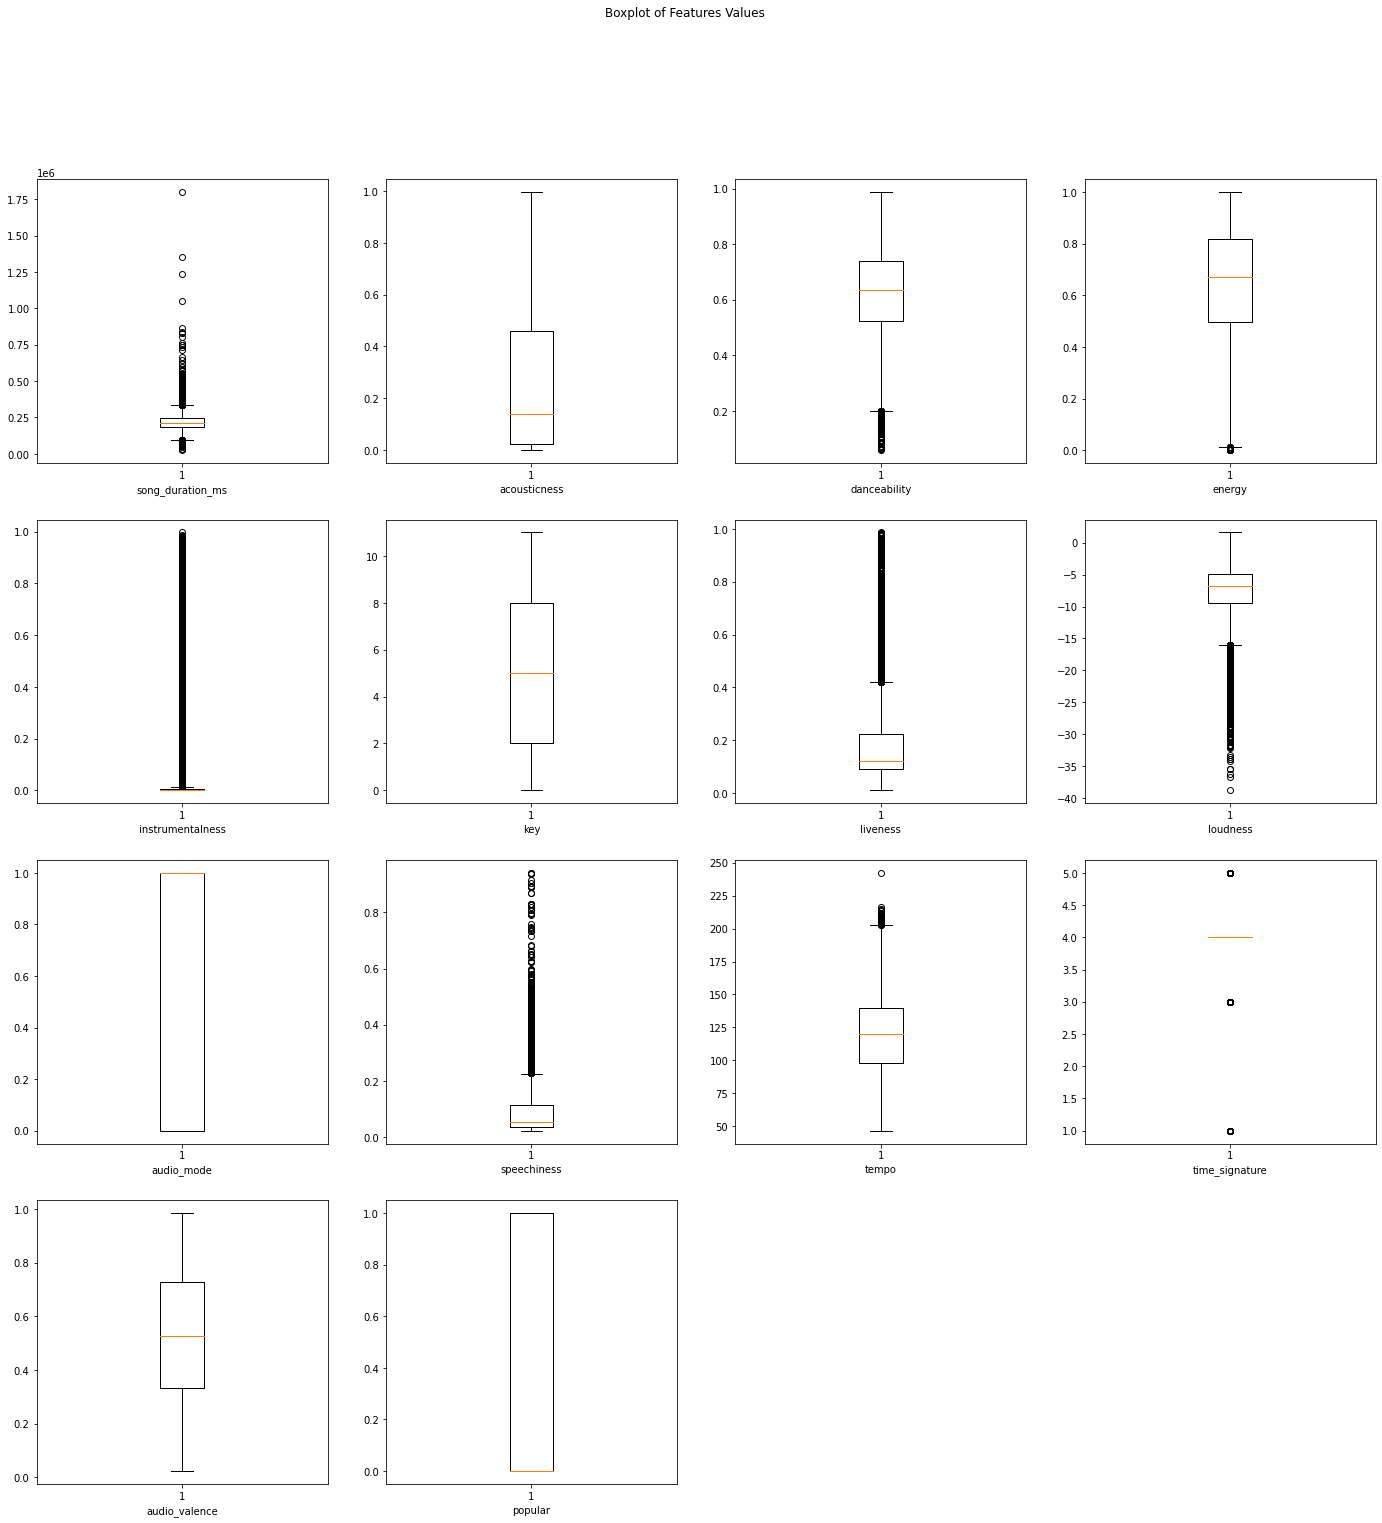

In [13]:
data = []
for col in song_data.columns[1:]:
    if col != 'song_popularity':
        data.append(song_data[col])

fig, ax = plt.subplots(4,4,figsize=(24, 24))
for i in range(0,14):
    ax[i//4][i % 4].boxplot(data[i])
    ax[i//4][i % 4].set_xlabel(data[i].name)
fig.delaxes(ax[3][2])
fig.delaxes(ax[3][3])
plt.suptitle("Boxplot of Features Values")
plt.show()

Boxplot of feature values gives us an idea of where most values lie & their range. Outliers are present and this is expected given each song's unique features

# Contributors to Popularity

### Key of Song
0 = C, 1 = C♯/D♭, 2 = D, and so on

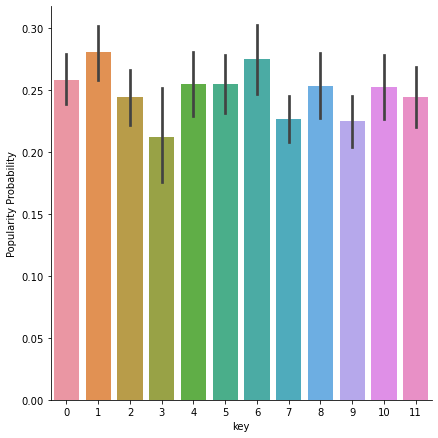

In [13]:
# key vs popularity
song_data[["key","popular"]].groupby(["key"], as_index = False).mean().sort_values(by="popular",ascending = False)

# Visualizing keys and popularity
g = sns.factorplot(x = "key", y = "popular", data = song_data, kind = "bar", size = 6)
g.set_ylabels("Popularity Probability")
plt.show()

### Audio Mode

audio_mode: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

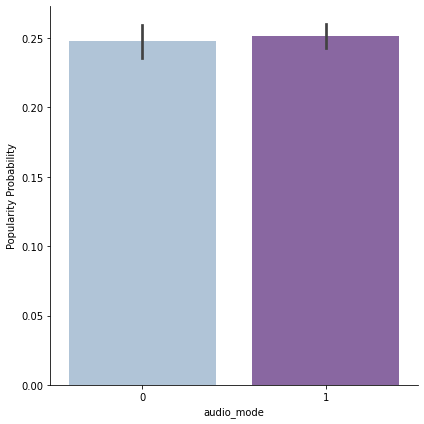

In [15]:
# audio_mode vs popularity
song_data[["audio_mode","popular"]].groupby(["audio_mode"], as_index = False).mean().sort_values(by="popular",ascending = False)
g = sns.factorplot(x = "audio_mode", y = "popular", data = song_data, kind = "bar", size = 6,palette = 'BuPu')
g.set_ylabels("Popularity Probability")
plt.show()

### Time Signature
An estimated overall time signature of a track. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure).


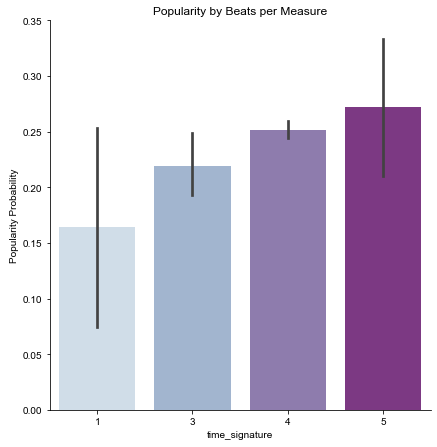

In [24]:
song_data[["time_signature","popular"]].groupby(["time_signature"], as_index = False).mean().sort_values(by="popular",ascending = False)

#time signature vs. popularity
g = sns.factorplot(x = "time_signature", y = "popular", data = song_data, kind = "bar", size = 6, palette = 'BuPu')
g.set_ylabels("Popularity Probability")
sns.set_style('dark')
g.set(title = "Popularity by Beats per Measure")
plt.show()

### Acousticness
 A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

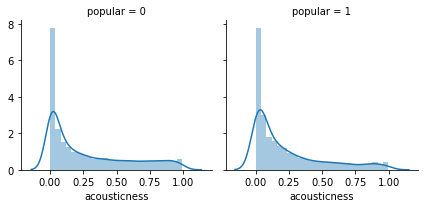

In [23]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "acousticness", bins = 25)
plt.show()

### Liveliness
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.


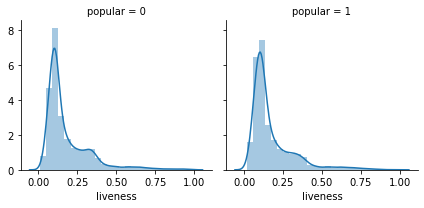

In [22]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "liveness", bins = 25)
plt.show()

### Danceability
Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.


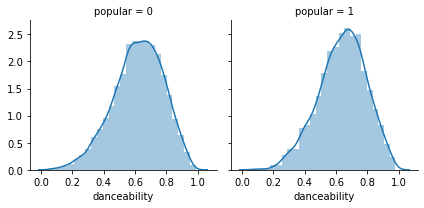

In [21]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "danceability", bins = 25)
plt.show()

### Loudness
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.


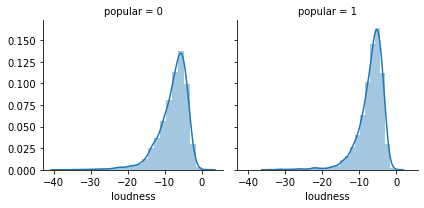

In [20]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "loudness", bins = 25)
plt.show()

### Instrumentalness
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.


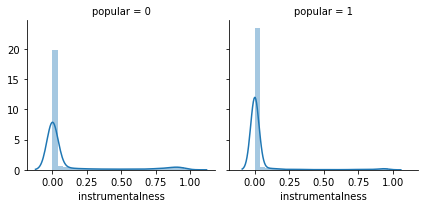

In [19]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "instrumentalness", bins = 25)
plt.show()

### Speechiness
Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music.Values below 0.33 most likely represent music and other non-speech-like tracks.


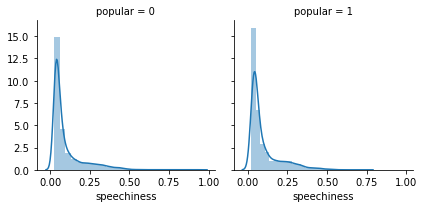

In [18]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "speechiness", bins = 25)
plt.show()

### Tempo
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.


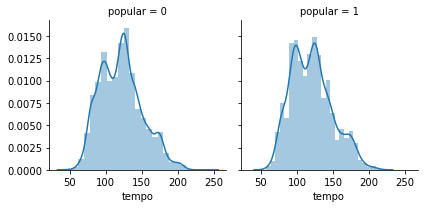

In [17]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "tempo", bins = 25)
plt.show()

### Audio Valence
A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).


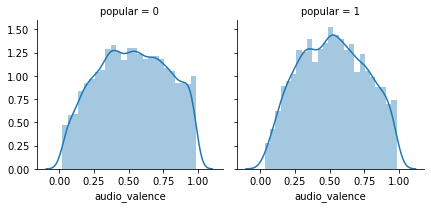

In [16]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "audio_valence", bins = 25)
plt.show()

### Energy
Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.


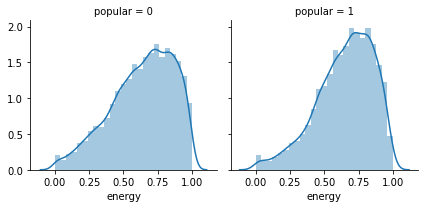

In [15]:
g = sns.FacetGrid(song_data, col = "popular")
g.map(sns.distplot, "energy", bins = 25)
plt.show()

### Happy & Energetic Songs

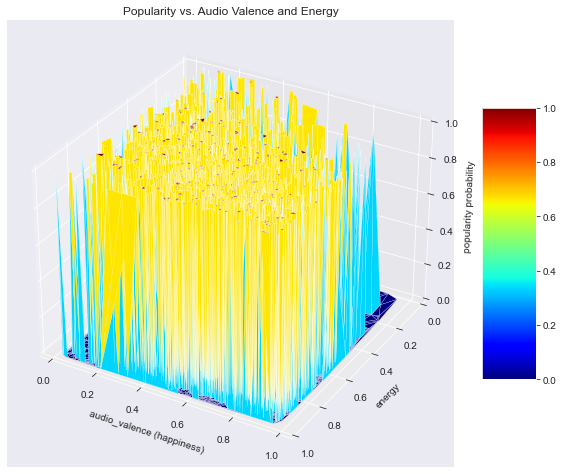

In [27]:
from matplotlib import cm
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
surf = ax.plot_trisurf(song_data['audio_valence'],song_data['energy'],song_data['popular'],cmap=cm.jet, linewidth=0.2)
ax.set_ylim(1,0)
g.set_ylabels("Popularity Probability")

ax.set_xlabel("audio_valence (happiness)")
ax.set_ylabel("energy")
ax.set_zlabel("popularity probability")
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_title("Popularity vs. Audio Valence and Energy")
plt.show()

### Contributor Summary
- Overall, we don't see a significant difference between the distributions of the above features for popular and unpopular songs. 
- Happier and more energetic songs do gain slightly more popularity over the less happy & energetic songs

### Interesting points - unrelated to model analysis 
### Atist popularity

Text(0.5, 1.0, 'Popularity by Artists with 10 or More Songs')

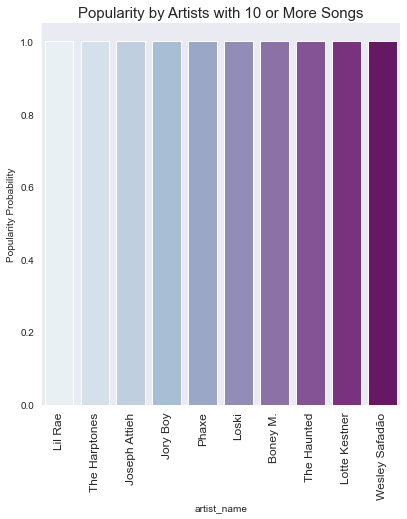

In [30]:
# Popularity by Artists - not included in argorithms
table = pd.pivot_table(song_data2, values=['song_name','popular'], index='artist_name',aggfunc= {'song_name':'count','popular':np.mean})
#table = table[table.song_name > 10]
table = table.sort_values('popular',ascending = False)
table.reset_index(level=0, inplace=True)

#draw graph
g = sns.factorplot(x = 'artist_name', y = 'popular', data = table.head(10), kind = "bar", size = 6, palette = 'BuPu')
g.set_ylabels("Popularity Probability")
plt.xticks(rotation=90,size = 12)
plt.title('Popularity by Artists with 10 or More Songs', size = 15)


### Interesting points - unrelated to model analysis 
### Playlist popularity

Text(0.5, 1.0, 'Popularity by Playlist')

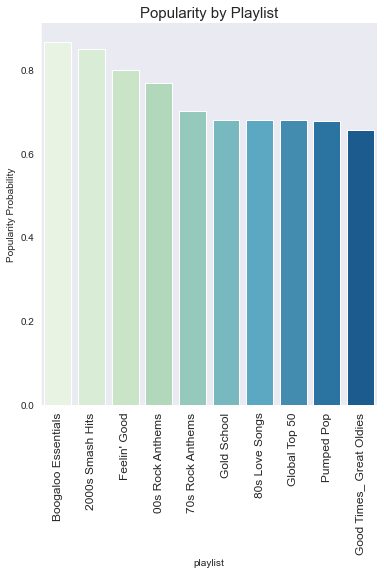

In [31]:
# Popularity by Artists - not included in argorithms
table_playlist = pd.pivot_table(song_data2, values= 'popular', index='playlist',aggfunc= np.mean)
table_playlist = table_playlist.sort_values('popular',ascending = False)
table_playlist.reset_index(level=0, inplace=True)

#draw graph
g = sns.factorplot(x = 'playlist', y = 'popular', data = table_playlist.head(10), kind = "bar", size = 6, palette = 'GnBu')
g.set_ylabels("Popularity Probability")
plt.xticks(rotation=90,size = 12)
plt.title('Popularity by Playlist', size = 15)

### Artist & Playlist Summary
- Using the supplement dataset, song_info, which contains artist name, album name and playlist. We explored artist popularity and playlist popularity.<br>
- A total of 152 artists are included in the dataset. Many, although obtaining high average popularity, only has a 1 song (Lil Rae, The Harptones,Jory Boy  and etc) <br>
- Artists who has more than 10 songs are ranked by their song popularity <br>
- Top five popular playlists are also shown above


# Machine Learning Models to Predict Popular Songs

### Standardize Features
1. binarize categorical features into dummy variables <br>
2. standardize the continuous features using (value-min)/(max-min)

In [25]:
#binarize categorical features
enhanced_feature = song_data.copy()
enhanced_feature["key"] = enhanced_feature["key"].astype("category")
enhanced_feature = pd.get_dummies(enhanced_feature, columns=["key"])
enhanced_feature["audio_mode"] = enhanced_feature["audio_mode"].astype("category")
enhanced_feature = pd.get_dummies(enhanced_feature, columns=["audio_mode"])
enhanced_feature["time_signature"] = enhanced_feature["time_signature"].astype("category")
enhanced_feature = pd.get_dummies(enhanced_feature, columns=["time_signature"])

column= ["key_0","key_1","key_2","key_3","key_4","key_5","key_6","key_7","key_8","key_9","key_10","key_11","audio_mode_0","audio_mode_1","time_signature_1","time_signature_3","time_signature_4","time_signature_5"]
for i in column:
    enhanced_feature[i] = enhanced_feature[i].astype(int)

#normalization
column2 = ["song_duration_ms", "acousticness","danceability","energy","instrumentalness","liveness","loudness","speechiness","tempo","audio_valence"]
for col in column2:
    enhanced_feature[col] = (enhanced_feature[col]-np.min(enhanced_feature[col]))/(np.max(enhanced_feature[col]-np.min(enhanced_feature[col])))

enhanced_feature.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,...,key_8,key_9,key_10,key_11,audio_mode_0,audio_mode_1,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,Boulevard of Broken Dreams,73,0.133179,0.005541,0.470677,0.682342,0.000029,0.049226,0.859242,0.007620,...,1,0,0,0,0,1,0,0,1,0
1,In The End,66,0.107575,0.010340,0.520267,0.853697,0.000000,0.099580,0.801948,0.029828,...,0,0,0,0,1,0,0,0,1,0
2,Seven Nation Army,76,0.115921,0.008202,0.730487,0.462888,0.448345,0.250333,0.766734,0.061833,...,0,0,0,0,0,1,0,0,1,0
3,By The Way,74,0.107575,0.026505,0.422165,0.970940,0.003561,0.093426,0.838352,0.092097,...,0,0,0,0,0,1,0,0,1,0
4,How You Remind Me,56,0.111462,0.000957,0.417853,0.766517,0.000000,0.104707,0.835204,0.009689,...,0,0,1,0,0,1,0,0,1,0


### Data Split 
using 80/20 split into training & testing

In [28]:
enhanced_ml = enhanced_feature.drop(["song_popularity","song_name"],axis=1)

#data preparation
y = enhanced_ml["popular"].values
x = enhanced_ml.drop(["popular"],axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=42)

y_train = y_train.astype(int).T
y_test = y_test.astype(int).T
print(song_data.shape)
print("x_train: ",x_train.shape)
print("x_test: ",x_test.shape)
print("y_train: ",y_train.shape)
print("y_test: ",y_test.shape)

(14923, 16)
x_train:  (11938, 28)
x_test:  (2985, 28)
y_train:  (11938,)
y_test:  (2985,)


### Logistic Regression

accuracy of baseline LG is 0.759463986599665


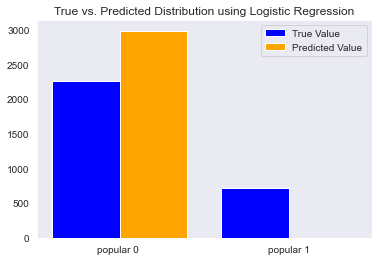

confusion matrix for tuned baseline LG


array([[2267,    0],
       [ 718,    0]], dtype=int64)

In [33]:
lg = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
lg.fit(x_train,y_train)
y_pred = lg.predict(x_test)
lg_f1 = accuracy_score(y_test, y_pred)

print("accuracy of baseline LG is",lg_f1)
#plot the outcome
x_axis = np.arange(1,3)
test_bar = [len(y_test)-np.sum(y_test),np.sum(y_test)]
pred_bar = [len(y_pred)-np.sum(y_pred),np.sum(y_pred)]
plt.bar(x_axis - 0.2,test_bar, 0.4, label = 'True Value',color = 'blue')
plt.bar(x_axis + 0.2, pred_bar, 0.4, label = 'Predicted Value',color = 'orange')
plt.xticks(x_axis, ['popular 0 ','popular 1'])
plt.legend()
plt.title("True vs. Predicted Distribution using Logistic Regression")
plt.show()
#confusion matrix for the outcome
print("confusion matrix for tuned baseline LG")
confusion_matrix(y_test, y_pred)

Tuned hyperparameters : {'C': 0.001, 'penalty': 'l2'}
grid search accuracy 0.759463986599665


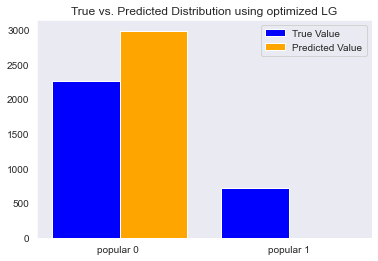

confusion matrix for tuned LG


array([[2267,    0],
       [ 718,    0]], dtype=int64)

In [32]:
#Gridesearch CV to find the best parameter
param_grid = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}
grid = GridSearchCV(LogisticRegression(),param_grid,cv=5)
grid.fit(x_train,y_train)

best_param = grid.best_params_
print("Tuned hyperparameters : {}".format(grid.best_params_))
#build a new LG model using tuned parameters
lg2 = LogisticRegression(C=best_param['C'],penalty = best_param['penalty'])
lg2.fit(x_train,y_train)
grid_pred = lg2.predict(x_test)
print('grid search accuracy',accuracy_score(y_test, grid_pred))

#plot the outocme
x_axis = np.arange(1,3)
test_bar = [len(y_test)-np.sum(y_test),np.sum(y_test)]
pred_bar = [len(grid_pred)-np.sum(grid_pred),np.sum(y_pred)]
plt.bar(x_axis - 0.2,test_bar, 0.4, label = 'True Value',color = 'blue')
plt.bar(x_axis + 0.2, pred_bar, 0.4, label = 'Predicted Value',color = 'orange')
plt.xticks(x_axis, ['popular 0 ','popular 1'])
plt.legend()
plt.title("True vs. Predicted Distribution using optimized LG")
plt.show()
#confuion matrix for the outcome
print("confusion matrix for tuned LG")
confusion_matrix(y_test, grid_pred)

In [35]:
#cross validation
k = 10
#using tuned hyperparameters
cv_result = cross_val_score(lg2,x,y,cv=k)
#print('Cross_val Scores: ',cv_result)
print('Cross_val scores average LG: ',np.sum(cv_result)/k)

Cross_val scores average LG:  0.7499162759544541


### Logistic Regression Model Summary
- Using basid logistic regression, accuracy of 75.9% is achieved. The model predicts all data as not popular in the test set (due to unbalanced dataset).<br>
- After parameter tuning using GridsearchCV, the best C parameter is 0.001 (as opposed to 1.0 in the default baseline). But that did not improve model accuracy, implying minimal impact of overfitting<br>
- Using cross validation, we can make predictions on all our data - we can expect our model to perform at ~75% accuracy on unseen data

### KNN

With KNN (K=3) test accuracy is:  0.6941373534338359


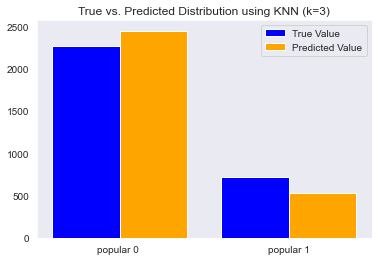

confusion matrix using basic knn (k=3)


array([[1902,  365],
       [ 548,  170]], dtype=int64)

In [38]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train,y_train)
pred_knn = knn.predict(x_test)
print('With KNN (K=3) test accuracy is: ',knn.score(x_test,y_test))
#plot the outcome
x_axis = np.arange(1,3)
test_bar = [len(y_test)-np.sum(y_test),np.sum(y_test)]
pred_bar = [len(pred_knn)-np.sum(pred_knn),np.sum(pred_knn)]
plt.bar(x_axis - 0.2,test_bar, 0.4, label = 'True Value',color = 'blue')
plt.bar(x_axis + 0.2, pred_bar, 0.4, label = 'Predicted Value',color = 'orange')
plt.xticks(x_axis, ['popular 0 ','popular 1'])
plt.legend()
plt.title("True vs. Predicted Distribution using KNN (k=3)")
plt.show()
#confusion matrix of the outcome
print("confusion matrix using basic knn (k=3)")
confusion_matrix(y_test,pred_knn)

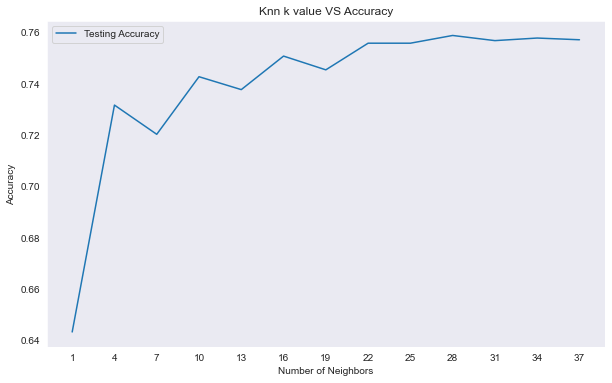

Best accuracy is 0.7587939698492462 with K = 10


In [39]:
#try different values for number of neighbors 
nb = np.arange(1, 39,3)
test_accuracy = []

for i, k in enumerate(nb):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train,y_train)
    test_accuracy.append(knn.score(x_test, y_test))
#plot accuracy vs. k
plt.figure(figsize=[10,6])
plt.plot(nb, test_accuracy, label = 'Testing Accuracy')
#plt.plot(neig, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.title('Knn k value VS Accuracy')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.xticks(nb)
plt.show()
print("Best accuracy is {} with K = {}".format(np.max(test_accuracy),1+test_accuracy.index(np.max(test_accuracy))))

With KNN (K=28) test accuracy is:  0.7587939698492462


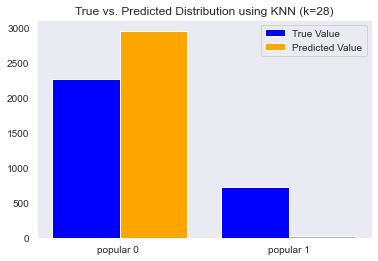

confusion matrix for KNN mode (k = 28)


array([[2251,   16],
       [ 704,   14]], dtype=int64)

In [42]:
knn2 = KNeighborsClassifier(n_neighbors = 28)
knn2.fit(x_train,y_train)
pred_knn2 = knn2.predict(x_test)
print('With KNN (K=28) test accuracy is: ',knn2.score(x_test,y_test))
#plot the outcome
x_axis = np.arange(1,3)
test_bar = [len(y_test)-np.sum(y_test),np.sum(y_test)]
pred_bar = [len(pred_knn2)-np.sum(pred_knn2),np.sum(pred_knn2)]
plt.bar(x_axis - 0.2,test_bar, 0.4, label = 'True Value',color = 'blue')
plt.bar(x_axis + 0.2, pred_bar, 0.4, label = 'Predicted Value',color = 'orange')
plt.xticks(x_axis, ['popular 0 ','popular 1'])
plt.legend()
plt.title("True vs. Predicted Distribution using KNN (k=28)")
plt.show()
#confusion matrix for the outcome
print("confusion matrix for KNN mode (k = 28)")
confusion_matrix(y_test,pred_knn2)

In [43]:
#cross validation
k = 10
cv_result = cross_val_score(knn2,x,y,cv=k) # uses R^2 as score 
cv_result_randomforest=np.sum(cv_result)/k
#print('Cross_val Scores: ',cv_result)
print('Cross_val scores average KNN (k=28): ',np.sum(cv_result)/k)

Cross_val scores average KNN (k=28):  0.7456276295635217


### Logistic Regression Model Summary
- using an arbitrary n_neighbor of 3, KNN model predicts with 69% accuracy <br>
- iterating over different k values, number 28 seems to produce the best accuracy of 75.9%<br>
- this result is consistent with the model accuracy of Logistic Regression<br>
- using 10 fold cross validation, we can expect the model to achieve 74.5% accuracy on average on new data

# Decision Tree vs Random Forest Classifier

Accuracy of decision tree: 0.6415410385259631


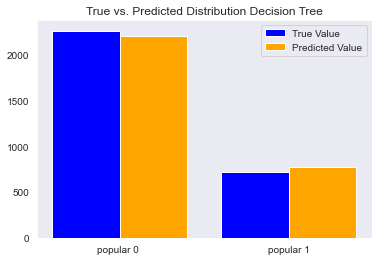

confusion matrix for decision tree


array([[1705,  562],
       [ 508,  210]], dtype=int64)

In [51]:
#decision tree
dt= DecisionTreeClassifier()
dt.fit(x_train,y_train)
y_pred_dt=dt.predict(x_test)
#print("Train ccuracy of decision tree:",dt.score(x_train,y_train))
print("Accuracy of decision tree:",accuracy_score(y_test, y_pred_dt))
#plot of prediction results
x_axis = np.arange(1,3)
test_bar_dt = [len(y_test)-np.sum(y_test),np.sum(y_test)]
pred_bar_dt = [len(y_pred_dt)-np.sum(y_pred_dt),np.sum(y_pred_dt)]
plt.bar(x_axis - 0.2,test_bar_dt, 0.4, label = 'True Value',color = 'blue')
plt.bar(x_axis + 0.2, pred_bar_dt, 0.4, label = 'Predicted Value',color = 'orange')
plt.xticks(x_axis, ['popular 0 ','popular 1'])
plt.legend()
plt.title("True vs. Predicted Distribution Decision Tree")
plt.show()
#confusion matrix of output
print("confusion matrix for decision tree")
confusion_matrix(y_test,y_pred_dt)

In [88]:
importances = dt.feature_importances_
forest_importances = pd.Series(importances, index=x_train.columns)
print(forest_importances)

song_duration_ms    0.101323
acousticness        0.097123
danceability        0.097052
energy              0.096869
instrumentalness    0.082217
liveness            0.083090
loudness            0.098618
speechiness         0.080366
tempo               0.087262
audio_valence       0.085004
key_0               0.008876
key_1               0.008253
key_2               0.003972
key_3               0.001573
key_4               0.006368
key_5               0.006678
key_6               0.007941
key_7               0.005267
key_8               0.004819
key_9               0.007226
key_10              0.006238
key_11              0.008467
audio_mode_0        0.005971
audio_mode_1        0.004071
time_signature_1    0.000573
time_signature_3    0.001982
time_signature_4    0.001737
time_signature_5    0.001062
dtype: float64


In [91]:
#random forest
rf=RandomForestClassifier(n_estimators=200)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
print("Test accuracy of random forest",rf.score(x_test,y_test))


Test accuracy of random forest 0.7604690117252931


Used this article for details on tuning paramters for a random forest tree:https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [92]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [200, 400, 600, 800]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 60, 80, 100, None]
# Minimum number of samples required to split a node
min_samples_split = [2, 5,10]
# Method of selecting samples for training each tree
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 400, 600, 800], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 60, 80, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [93]:
 from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, random_state=42)
# Fit the random search model
rf_random.fit(x_train, y_train)

print(rf_random.best_params_)


{'n_estimators': 600, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None}


In [94]:
best_random = rf_random.best_estimator_
# predictions = best_random.predict(x_test)
print(best_random.score(x_test,y_test))
# errors = abs(predictions - y_test)
# mape = 100 * np.mean(errors / y_test)
# accuracy_rf = 100 - mape
# print('Accuracy = {:0.2f}%.'.format(accuracy_rf))

0.06158246562983727


In [47]:
confusion_matrix(y_test,y_pred_rf)

array([[2212,   55],
       [ 657,   61]])

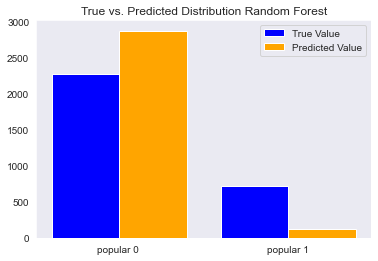

In [48]:
x_axis = np.arange(1,3)
test_bar_rf = [len(y_test)-np.sum(y_test),np.sum(y_test)]
pred_bar_rf = [len(y_pred_rf)-np.sum(y_pred_rf),np.sum(y_pred_rf)]
plt.bar(x_axis - 0.2,test_bar_rf, 0.4, label = 'True Value',color = 'blue')
plt.bar(x_axis + 0.2, pred_bar_rf, 0.4, label = 'Predicted Value',color = 'orange')
plt.xticks(x_axis, ['popular 0 ','popular 1'])
plt.legend()
plt.title("True vs. Predicted Distribution Random Forest")
plt.show()

In [49]:
importances = dt.feature_importances_
forest_importances = pd.Series(importances, index=x_train.columns)
print(forest_importances)

song_duration_ms    0.104500
acousticness        0.098586
danceability        0.094191
energy              0.093785
instrumentalness    0.082932
liveness            0.082380
loudness            0.101634
speechiness         0.084517
tempo               0.088221
audio_valence       0.079938
key_0               0.008694
key_1               0.006836
key_2               0.003417
key_3               0.001047
key_4               0.005440
key_5               0.008451
key_6               0.008334
key_7               0.005942
key_8               0.005624
key_9               0.005221
key_10              0.005630
key_11              0.006451
audio_mode_0        0.007122
audio_mode_1        0.004474
time_signature_1    0.000573
time_signature_3    0.002525
time_signature_4    0.002067
time_signature_5    0.001467
dtype: float64


In [50]:
k = 10
cv_result = cross_val_score(rf,x,y,cv=k) # uses R^2 as score 
cv_result_randomforest=np.sum(cv_result)/k
#print('Cross_val Scores: ',cv_result)
print('Cross_val scores average: ',np.sum(cv_result)/k)

Cross_val scores average:  0.7464990779131927


# Summary (to be filled out)